# Sparse regression

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()

## Model

In [2]:
from tramp.experiments import TeacherStudentScenario
from tramp.models import SparseRegression

sparse_reg = SparseRegression(
  ensemble=GaussianEnsemble(),
  prior=GaussBernouilliPrior(size=100,rho=0.5,mean=0,var=1),
  linear=LinearChannel(Nx=50,Nz=100,precompute_svd=True),
  output=GaussianChannel(var=1e-06)
)


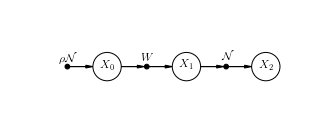

In [3]:
sparse_reg = SparseRegression(N=100, alpha=0.5, ensemble_type="gaussian", var_noise=1e-6, rho=0.5)
print(f"sparse_reg = {sparse_reg}")
sparse_reg.daft()

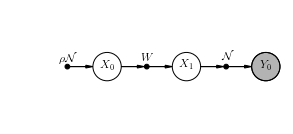

In [4]:
scenario = TeacherStudentScenario(sparse_reg)
scenario.setup()
scenario.student.daft()

## Experiments

In [5]:
def run_sparse_regression(N, alpha, ensemble_type, rho, var_noise):
    sparse_reg = SparseRegression(N, alpha, ensemble_type, rho, var_noise)
    scenario = TeacherStudentScenario(sparse_reg)
    scenario.setup()
    scenario.infer()
    return dict(
        mse_ep=scenario.mse_ep, n_iter_ep=scenario.n_iter_ep,
        mse_se=scenario.mse_se, n_iter_se=scenario.n_iter_se
    )

In [6]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)

csv_file = "data/sparse_regression_experiments.csv"

def run_experiments():
    result_handler = DataFrameResultHandler()
    task = Task(
        run_sparse_regression, 
        N=1000, ensemble_type="gaussian", var_noise = 1e-6, 
        rho=[0.25, 0.50, 0.75], alpha=np.linspace(0,1,50)[1:]
    )
    with progressbar() as on_progress:
        task.run(result_handler, on_progress)
    df = result_handler.get_dataframe()
    df.to_csv(csv_file, index=False)
    return df

In [7]:
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    df = run_experiments()

## Donoho Tanner phase transition

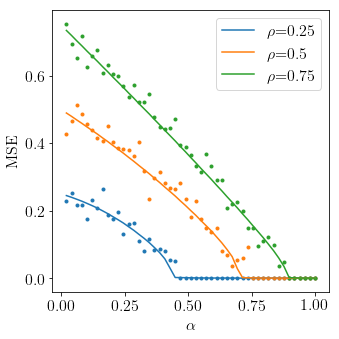

In [8]:
qplot(
    df, 
    x="alpha", y=["mse_se","mse_ep"], y_markers=["-","."], color="rho",
    figsize=5,
    rename={"mse_se, mse_ep":"MSE", "alpha":r"$\alpha$", "rho":r"$\rho$"},
    usetex=True, font_size=16
)


## Nbr of iterations diverging at the critical value

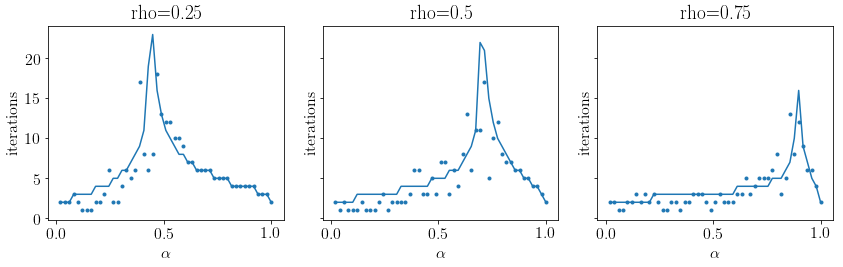

In [9]:
qplot(
    df, 
    x="alpha", y=["n_iter_se","n_iter_ep"], y_markers=["-","."], column="rho",
    rename={"n_iter_se, n_iter_ep":"$\mathrm{iterations}$", "alpha":r"$\alpha$", "p_pos":r"$p_+$"},
    usetex=True, font_size=16
)